In [1]:
import iris
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import datetime
import numpy as np
import iris.coords as icoords
import iris.coord_categorisation
import iris.quickplot as qplt 
import numpy.ma as ma
from iris.util import broadcast_to_shape
from matplotlib.lines import Line2D

In [2]:
#defining a function to calculate global average T
def area_average(cube):
    
    if cube.coord('latitude').bounds is None:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    
    grid_areas = iris.analysis.cartography.area_weights(cube)
    average = cube.collapsed(['latitude','longitude'],iris.analysis.MEAN, weights=grid_areas)
    
    return average

In [3]:
#defining function to reset cube time
def time_reset(cubes): 
    
    time_coord = cubes[0].coord('time')
    n=1
    for cube in cubes:
        cube.remove_coord('time')
        cube.add_dim_coord(time_coord,0)
        cube.remove_coord('forecast_reference_time')
        cube.remove_coord('forecast_period')
        n+=1
    
    return 

In [4]:
#defining function to merge cube list into single large cube
def merge_cubes(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    n=1
    for cube in cubes:
        ensemble_coord = icoords.AuxCoord(n, standard_name='realization')
        new_cube = cube.copy()
        new_cube.add_aux_coord(ensemble_coord)
        big_cube.append(new_cube)
        n+=1
    
    return big_cube.merge_cube()

In [5]:
#setting file path and ensemble cubes
#ensembles grouped by ENSO starting conditions
dir_in_coupled = '/shared/netscratch/lrm49/Laura/'
july_el = ['u-bw764'] 
july_la = ['u-bw758', 'u-bw761', 'u-bw762', 'u-bw766'] 
july_ne = ['u-bv020', 'u-bw763', 'u-bw765', 'u-bw767']
jan_el = ['u-ca322', 'u-ca325', 'u-ca331'] 
jan_la = ['u-ca323', 'u-ca324', 'u-ca326', 'u-ca328'] 
jan_ne = ['u-ca327', 'u-ca330' ]


In [6]:
## EL NINO ## 
saod_elnino = iris.cube.CubeList()
for job_id in july_el:

    SAOD_cubes = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_optical_vars.nc')
    total_SAOD = SAOD_cubes[0] + SAOD_cubes[2] + SAOD_cubes[3] + SAOD_cubes[4] #loading in all aerosol modes
    total_SAOD_550 = total_SAOD.extract(iris.Constraint(pseudo_level = 3))[6:120] #550nm level

    saod_elnino.append(total_SAOD_550)
    
for job_id in jan_el:
    
    SAOD_cubes = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_optical_vars.nc')
    total_SAOD = SAOD_cubes[0] + SAOD_cubes[2] + SAOD_cubes[3] + SAOD_cubes[4] #loading in all aerosol modes
    total_SAOD_550 = total_SAOD.extract(iris.Constraint(pseudo_level = 3))[0:114] #550nm level

    saod_elnino.append(total_SAOD_550)

In [7]:
## LA NINA ## 
saod_lanina = iris.cube.CubeList()
for job_id in july_la:

    SAOD_cubes = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_optical_vars.nc')
    total_SAOD = SAOD_cubes[0] + SAOD_cubes[2] + SAOD_cubes[3] + SAOD_cubes[4] #loading in all aerosol modes
    total_SAOD_550 = total_SAOD.extract(iris.Constraint(pseudo_level = 3))[6:120] #550nm level

    saod_lanina.append(total_SAOD_550)
    
for job_id in jan_la:
    
    SAOD_cubes = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_optical_vars.nc')
    total_SAOD = SAOD_cubes[0] + SAOD_cubes[2] + SAOD_cubes[3] + SAOD_cubes[4] #loading in all aerosol modes
    total_SAOD_550 = total_SAOD.extract(iris.Constraint(pseudo_level = 3))[0:114] #550nm level

    saod_lanina.append(total_SAOD_550)

In [8]:
## NEUTRAL ## 
saod_neutral = iris.cube.CubeList()
for job_id in july_ne:

    SAOD_cubes = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_optical_vars.nc')
    total_SAOD = SAOD_cubes[0] + SAOD_cubes[2] + SAOD_cubes[3] + SAOD_cubes[4] #loading in all aerosol modes
    total_SAOD_550 = total_SAOD.extract(iris.Constraint(pseudo_level = 3))[6:120] #550nm level

    saod_neutral.append(total_SAOD_550)
    
for job_id in jan_ne:
    
    SAOD_cubes = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_optical_vars.nc')
    total_SAOD = SAOD_cubes[0] + SAOD_cubes[2] + SAOD_cubes[3] + SAOD_cubes[4] #loading in all aerosol modes
    total_SAOD_550 = total_SAOD.extract(iris.Constraint(pseudo_level = 3))[0:114] #550nm level

    saod_neutral.append(total_SAOD_550)

In [9]:
# Resetting time
time_reset(saod_elnino)
time_reset(saod_lanina)
time_reset(saod_neutral)

In [10]:
#merging list of cubes into single large cube
one_big_elnino = merge_cubes(saod_elnino)
one_big_lanina = merge_cubes(saod_lanina)
one_big_neutral = merge_cubes(saod_neutral)

In [11]:
## EL NINO ## 
NH_constraint = iris.Constraint(latitude=lambda v: 0 <= v <= 90)#Northern Hemisphere
SH_constraint = iris.Constraint(latitude=lambda v: -90 <= v <= 0)#Southern Hemisphere

# calcualting SAOD ratio 

elnino_ratio = iris.cube.CubeList()

for i in range(0,4):
    nh_saod = saod_elnino[i].extract(NH_constraint)
    sh_saod = saod_elnino[i].extract(SH_constraint)
    nh_avg = area_average(nh_saod)
    sh_avg = area_average(sh_saod)
    ratio = (nh_avg - sh_avg) / (nh_avg + sh_avg)
               
    elnino_ratio.append(ratio)

In [12]:
## LA NINA ##
NH_constraint = iris.Constraint(latitude=lambda v: 0 <= v <= 90)#Northern Hemisphere
SH_constraint = iris.Constraint(latitude=lambda v: -90 <= v <= 0)#Southern Hemisphere

# calcualting SAOD ratio 

lanina_ratio = iris.cube.CubeList()

for i in range(0,8):
    nh_saod = saod_lanina[i].extract(NH_constraint)
    sh_saod = saod_lanina[i].extract(SH_constraint)
    nh_avg = area_average(nh_saod)
    sh_avg = area_average(sh_saod)
    ratio = (nh_avg - sh_avg) / (nh_avg + sh_avg)
               
    lanina_ratio.append(ratio)

In [13]:
## NEUTRAL ## 
NH_constraint = iris.Constraint(latitude=lambda v: 0 <= v <= 90)#Northern Hemisphere
SH_constraint = iris.Constraint(latitude=lambda v: -90 <= v <= 0)#Southern Hemisphere

# calcualting SAOD ratio 
neutral_ratio = iris.cube.CubeList()

for i in range(0,6):
    nh_saod = saod_neutral[i].extract(NH_constraint)
    sh_saod = saod_neutral[i].extract(SH_constraint)
    nh_avg = area_average(nh_saod)
    sh_avg = area_average(sh_saod)
    ratio = (nh_avg - sh_avg) / (nh_avg + sh_avg)
               
    neutral_ratio.append(ratio)

In [14]:
#merging ratio cubes 
big_elnino_ratios = merge_cubes(elnino_ratio)
big_lanina_ratios = merge_cubes(lanina_ratio)
big_neutral_ratios = merge_cubes(neutral_ratio)

In [15]:
#calculating mean SAOD ratio by grouping
mean_elnino = big_elnino_ratios.collapsed('realization',iris.analysis.MEAN)
mean_lanina = big_lanina_ratios.collapsed('realization',iris.analysis.MEAN)
mean_neutral = big_neutral_ratios.collapsed('realization',iris.analysis.MEAN)

/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'realization'.
  warnings.warn(msg.format(self.name()))


In [16]:
#defining new time
time_1 = range(0,114)

In [17]:
#zero line for plot
zero = []
for n in range(0,114):
    n = 0
    zero.append(n)

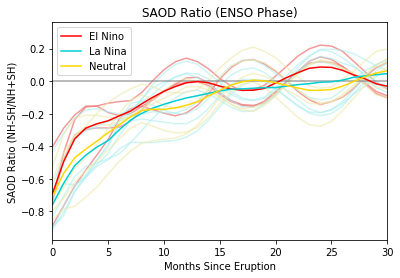

In [18]:
for cube in big_elnino_ratios.slices_over('realization'): # loop through ensemble members
    plt.plot(time_1,cube.data,color='lightcoral', alpha = 0.8)

for cube in big_lanina_ratios.slices_over('realization'): # loop through ensemble members
    plt.plot(time_1,cube.data,color='paleturquoise', alpha = 0.6)
    
for cube in big_neutral_ratios.slices_over('realization'): # loop through ensemble members
    plt.plot(time_1,cube.data,color='palegoldenrod', alpha = 0.6)

plt.plot(time_1,zero,color='grey', alpha = 0.7)#zero line

#plotting mean
plt.plot(time_1,mean_elnino.data,color='red')
plt.plot(time_1, mean_lanina.data,color='darkturquoise')
plt.plot(time_1, mean_neutral.data,color='gold')
    
plt.xlim(time_1[0],time_1[30]) # plot only 5 years

plt.title('SAOD Ratio (ENSO Phase)')
plt.xlabel('Months Since Eruption')
plt.ylabel('SAOD Ratio (NH-SH/NH+SH)')
elnino_line = Line2D([0], [0], label='El Nino', color='red')
lanina_line = Line2D([0], [0], label='La Nina', color='darkturquoise')
neutral_line = Line2D([0], [0], label='Neutral', color='gold')
plt.legend(handles=[elnino_line, lanina_line, neutral_line])

plt.savefig('SAOD_Ratio_ENSO.pdf')